## Dask deconvolution

With modern (many Gigabyte) image sizes it is often not possible to load the entire image into GPU memory.  And even if the entire image does fit into GPU memory keep in mind multiple buffers are needed to perform FFT Convolution and Deconvolution (remember how many buffers were needed for example 2).

In the case where we don't have enough GPU memory to perform the entire calculation, we can use Dask to load the image in chunks and perform the deconvolution on each chunk. This is a bit more complicated than the previous examples, but it is still possible to do it in just a few lines of code.

### Chunked deconvolution and edge handling

When applying deconvolution to chunks (a.k.a. blocks) of a larger image the edge handling strategy can become important because each chunk can have structure near the edges, especially when the boundaries of the chunks sub-divide extended objects.  If we are not careful we can get artifacts at the seams of the chunks.  There are a few factors that we need to consider to try and minimize boundary artifacts at the seams. 

1.  Overlap between the chunks

When we apply a filter to chunks we can specify an overlap value.  For a linear convolution kernel specifying an overlap equal to ```kerenel_size//2+1``` in each dimension would be sufficient to avoid seam artifacts.  However Richardson Lucy Deconvolution is an iterative non-linear operator so overlap alone is not enough to prevent seam artifacts.

2.  Edge handling strategy 

Using a robust edge handling strategy can reduce artifacts at seams.

###  Design trade-offs

1.  PSF size - Using a larger PSF may improve deconvolution quality by increasing the spatial extent of the deblurring.  However a larger PSF size requires larger overlap between chunks.  Note that the PSF size may be 'infinite' in thoeory (light from an emitter can propagate forever) however PSFs used for deconvolution are finite.  Thus the size of PSF used for deconvolution becomes a design parameter.

2.  Overlap - Larger overlaps will reduce artifacts, but increase processing time and memory by increasing the size of each chunk. 

### Simulation

In this example we do the following.

1.  Create a simulated image with a large sphere at the center.  This sample is useful to study chunking artifacts because the chunks will subdivide the sphere. 

2.  Convolve a PSF with the simulated image and add noise.  

3.  Define our chunk sizes, overlap and use Dask to deconvolve.  Note that we have the option of making the forward PSF size and deconvolution PSF size different.  We do this to simulate reality where the 'real' PSF can extend 'theoretically' forever (but practically the size is limited by the level of the signal that can be detected given camera limitations and nosie) but for digital image processing we use a finite PSF.  The PSF size used for deconvolution is a design parameter.  If larger we may bet better deconvolution, but if smaller we can save memory and time because the boundary and overlap sizes can be smaller. 


# Import Dask

In [1]:
import dask.array as da
from clij2fft.richardson_lucy import richardson_lucy_nc 
import numpy as np
import decon_helper as dh
from tnia.deconvolution.forward import forward

tnia available
stackview available


## Create the phantom

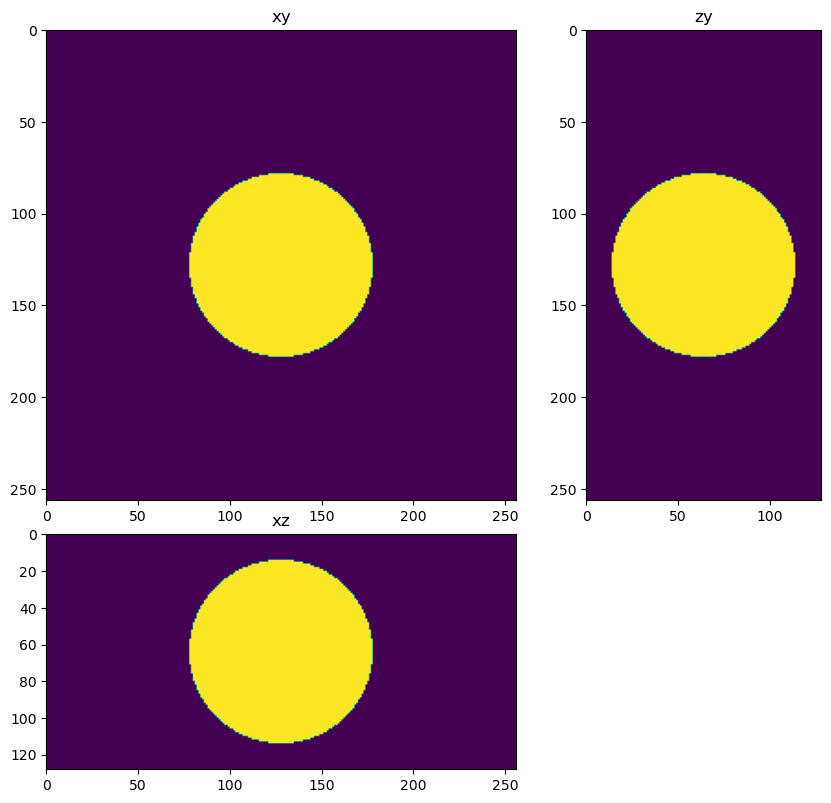

In [2]:
import raster_geometry as rg
from tnia.simulation.phantoms import add_small_to_large

zdim = 128
ydim = 256
xdim = 256

phantom = np.zeros((zdim,ydim,xdim), dtype=np.float32)

r=50
size = [2*r, 2*r, 2*r]
sphere = rg.sphere(size, r).astype(np.float32)

x=100
y=100
z=50

add_small_to_large(phantom, sphere, phantom.shape[2]//2, phantom.shape[1]//2, phantom.shape[0]//2)

dh.show_xyz_slice(phantom, imp='tnia')

## Create the forward PSF and deconvolution PSF

Note that the forward PSF (the PSF that explains the image) is not equal to the digital PSF used for deconvolution.  Among other imperfect approximations the PSF used for deconvolution can have smaller spatial extent.  In this simulation the PSF we use for convolution is larger than the PSF used for deconvolution.  We can change the size of the deconvolution PSF to study how different sizes of PSF affects the result.  

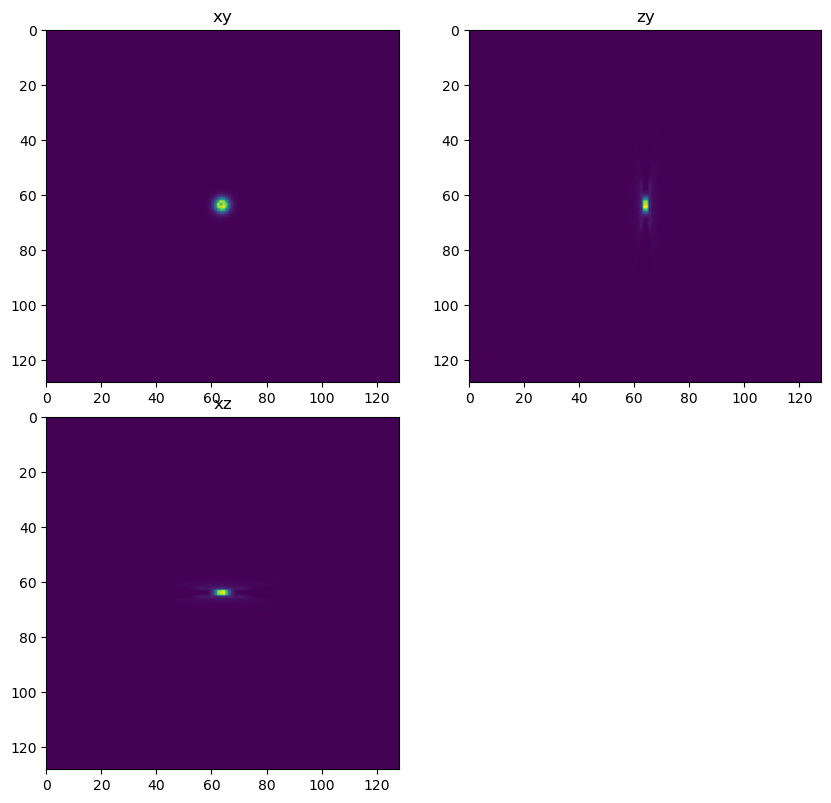

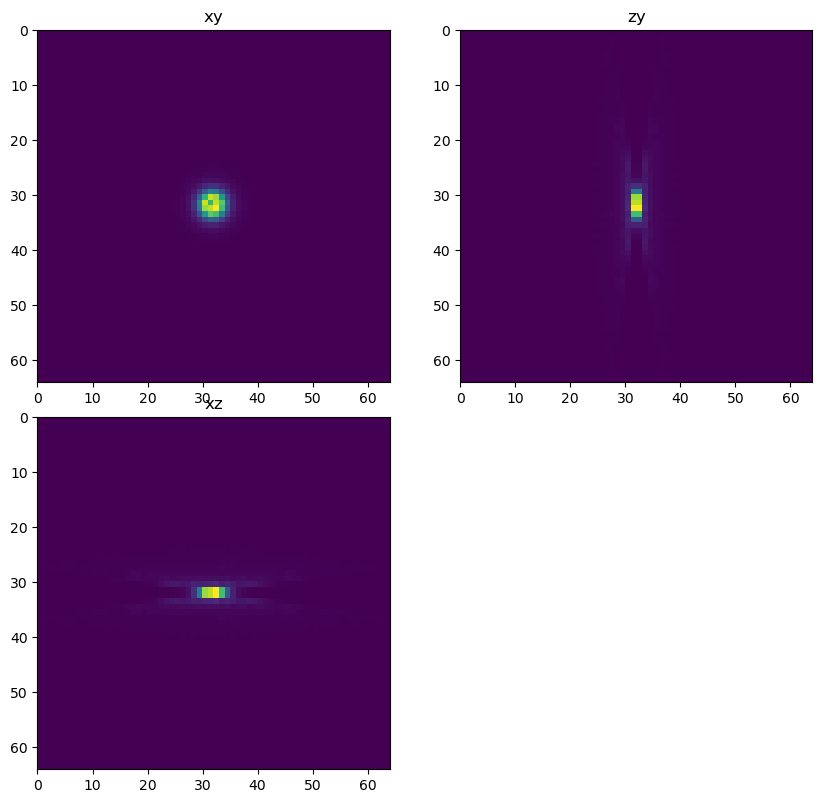

In [3]:
from tnia.deconvolution.psfs import gibson_lanni_3D

x_voxel_size = 0.372
z_voxel_size=2.8
#x_voxel_size = 0.1
#z_voxel_size=.8

xy_psf_dim_forward=128
z_psf_dim_forward=128

xy_psf_dim_decon=64
z_psf_dim_decon=64

NA=0.75
ni=1
ns=1

psf_forward  = gibson_lanni_3D(NA, ni, ns, x_voxel_size, z_voxel_size, xy_psf_dim_forward, z_psf_dim_forward, 0, 0.5, False, True)
psf_forward = psf_forward.astype('float32')
dh.show_xyz_slice(psf_forward, 'tnia')

psf_decon  = gibson_lanni_3D(NA, ni, ns, x_voxel_size, z_voxel_size, xy_psf_dim_decon, z_psf_dim_decon, 0, 0.5, False, True)
psf_decon = psf_decon.astype('float32')
dh.show_xyz_slice(psf_decon, 'tnia')

## Apply the forward model

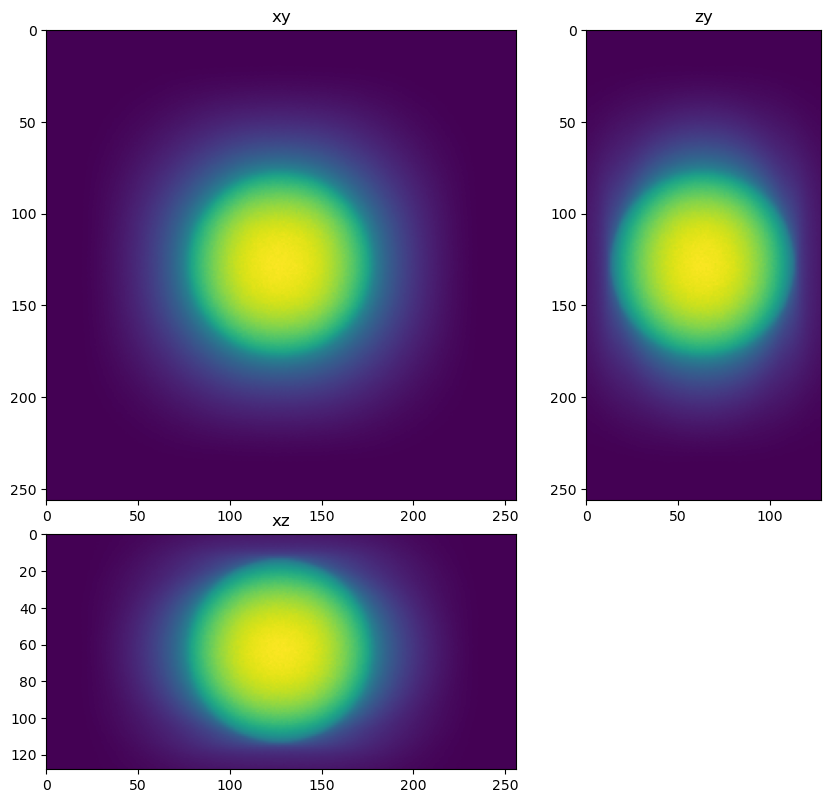

In [4]:
from tnia.deconvolution.forward import forward
from tnia.nd.ndutil import centercrop

gain = 100
im = forward(gain*phantom, psf_forward, 100, True, True)

dh.show_xyz_slice(im, 'tnia')

## Define number of chunks

Define the number of chunks to divide the image into. 

(In this example the image is relatively small so likely the image and arrays needed for FFT based calculations would fit into the GPU without chunking, in a real life example we would pre-compute the largest chunk size we could process given memory constraints and base the chunk size on that).

In [5]:
num_x_chunks = 2
num_y_chunks = 2
num_z_chunks = 1

z_chunk_size = im.shape[0]
y_chunk_size = int(im.shape[1]/num_x_chunks)
x_chunk_size = int(im.shape[2]/num_y_chunks)
print('chunks', z_chunk_size, y_chunk_size, x_chunk_size)


chunks 128 128 128


## Define the deconvolver

In [6]:
try:
    from clij2fft.richardson_lucy import richardson_lucy_nc, richardson_lucy 
    def deconv_chunk_rl_clij(img):
            print(img.shape,psf_decon.shape)
            result = richardson_lucy(img, psf_decon, iterations, reg)
            print('finished decon chunk')
            return result
            #return stack
except ImportError:
    print('clij2fft non-circulant rl not imported')
try:
    from clij2fft.richardson_lucy import richardson_lucy_nc 
    def deconv_chunk_rlnc_clij(img):
            print(img.shape,psf_decon.shape)
            result = richardson_lucy_nc(img, psf_decon, iterations, reg)
            print('finished decon chunk')
            return result
            #return stack
except ImportError:
    print('clij2fft non-circulant rl not imported')
try:
    import RedLionfishDeconv as rl
    print('redlionfish rl imported')
    def deconv_chunk_rlf(img):
        print(img.shape,psf_decon.shape)
        result = rl.doRLDeconvolutionFromNpArrays(img, psf_decon, niter=iterations, method='gpu', resAsUint8=False )
        print('finished decon chunk')
        return result
except ImportError:
    print('redlionfish rl not imported')



redlionfish rl imported


## Deconvolve in chunks with overlap between chunks

Here we call the dask deconvolution using an overlap factor to prevent edge artifacts between chunks.  We try all of the clij2-fft, clij2-fft non-circulant implementation of RL and the Red Lion fish implementation. 

(0, 0, 0) (64, 64, 64)
(128, 152, 152) (64, 64, 64)
get lib

Richardson Lucy Started
0 10 20 30 40 50 60 70 80 90 
Richardson Lucy Finishedfinished decon chunk
(128, 152, 152) (64, 64, 64)
get lib

Richardson Lucy Started
0 10 20 30 40 50 60 70 80 90 
Richardson Lucy Finishedfinished decon chunk
(128, 152, 152) (64, 64, 64)
get lib

Richardson Lucy Started
0 10 20 30 40 50 60 70 80 90 
Richardson Lucy Finishedfinished decon chunk
(128, 152, 152) (64, 64, 64)
get lib

Richardson Lucy Started
0 10 20 30 40 50 60 70 80 90 
Richardson Lucy Finishedfinished decon chunk
(0, 0, 0) (64, 64, 64)
get lib

Richardson Lucy Started
0 10 20 30 40 50 60 70 80 90 
Richardson Lucy Finishedfinished decon chunk
(128, 152, 152) (64, 64, 64)
get lib

Richardson Lucy Started
0 10 20 30 40 50 60 70 80 90 
Richardson Lucy Finishedfinished decon chunk
(128, 152, 152) (64, 64, 64)
get lib

Richardson Lucy Started
0 10 20 30 40 50 60 70 80 90 
Richardson Lucy Finishedfinished decon chunk
(128, 152, 152) (64, 64,

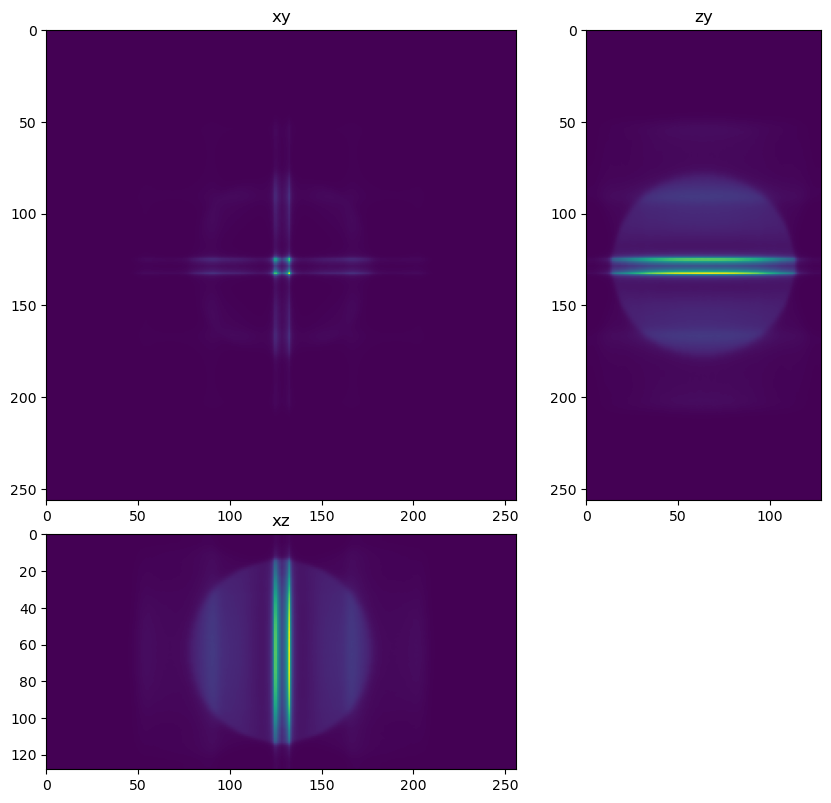

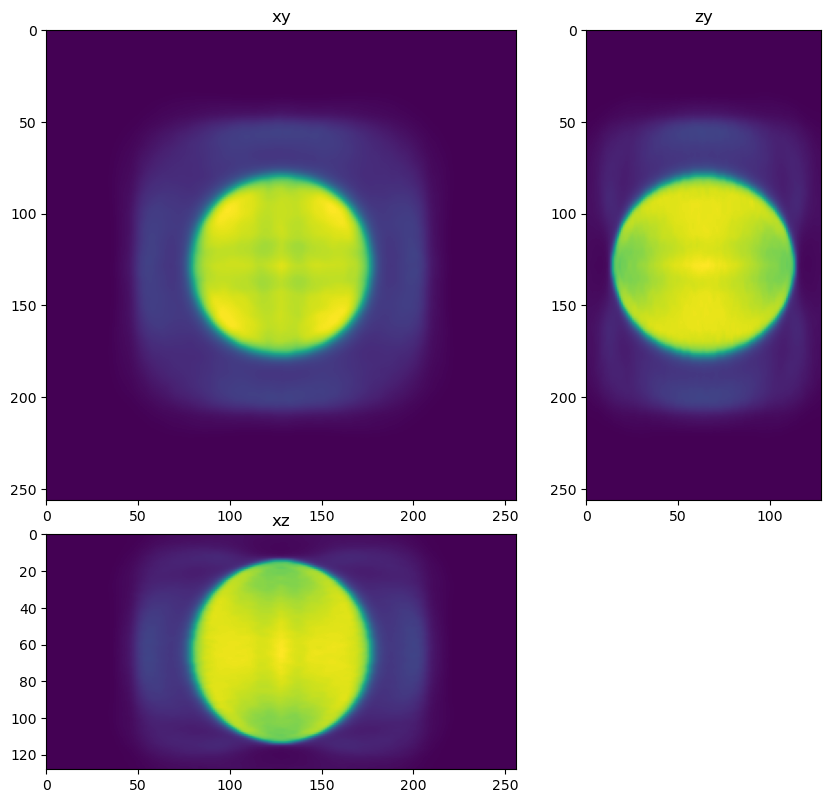

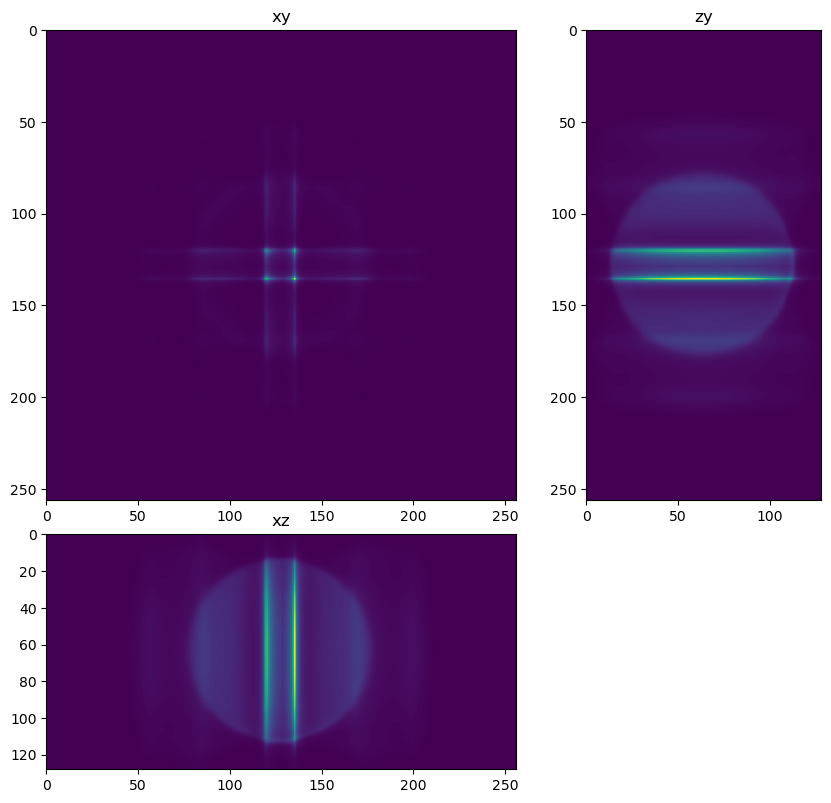

In [7]:
from tnia.plotting.projections import show_xyz_slice

iterations = 100
reg = 0.0001

overlap = 24
dimg = da.from_array(im,chunks=(z_chunk_size, y_chunk_size, x_chunk_size))

out_rl_clij = dimg.map_overlap(deconv_chunk_rl_clij, depth={0:0, 1:overlap, 2:overlap}, dtype=np.float32)
decon_overlap_24_rl_clij = out_rl_clij.compute(num_workers=1)

out_rlnc_clij = dimg.map_overlap(deconv_chunk_rlnc_clij, depth={0:0, 1:overlap, 2:overlap}, dtype=np.float32)
decon_overlap_24_rlnc_clij = out_rlnc_clij.compute(num_workers=1)

out_rlf = dimg.map_overlap(deconv_chunk_rlf, depth={0:0, 1:overlap, 2:overlap}, dtype=np.float32)
decon_overlap_24_rlf = out_rlf.compute(num_workers=1)

x_v = decon_overlap_24_rl_clij.shape[2]//2
y_v = decon_overlap_24_rl_clij.shape[1]//2
z_v = decon_overlap_24_rl_clij.shape[0]//2

fig = show_xyz_slice(decon_overlap_24_rl_clij, x_v, y_v, z_v)
fig = show_xyz_slice(decon_overlap_24_rlnc_clij, x_v, y_v, z_v)
fig = show_xyz_slice(decon_overlap_24_rlf, x_v, y_v, z_v)
    

## Deconvolve in chunks with different overlaps

Here we deconvolve in chunks without overlap (this will be a bit faster and use a little less memory) but as you can see we end up with artifacts on the seems of the chunks.

(0, 0, 0) (64, 64, 64)
get lib

Richardson Lucy Started
0 10 20 30 40 50 60 70 80 90 
Richardson Lucy Finishedfinished decon chunk
(128, 128, 128) (64, 64, 64)
get lib

Richardson Lucy Started
0 10 20 30 40 50 60 70 80 90 
Richardson Lucy Finishedfinished decon chunk
(128, 128, 128) (64, 64, 64)
get lib

Richardson Lucy Started
0 10 20 30 40 50 60 70 80 90 
Richardson Lucy Finishedfinished decon chunk
(128, 128, 128) (64, 64, 64)
get lib

Richardson Lucy Started
0 10 20 30 40 50 60 70 80 90 
Richardson Lucy Finishedfinished decon chunk
(128, 128, 128) (64, 64, 64)
get lib

Richardson Lucy Started
0 10 20 30 40 50 60 70 80 90 
Richardson Lucy Finishedfinished decon chunk
(0, 0, 0) (64, 64, 64)
get lib

Richardson Lucy Started
0 10 20 30 40 50 60 70 80 90 
Richardson Lucy Finishedfinished decon chunk
(128, 152, 152) (64, 64, 64)
get lib

Richardson Lucy Started
0 10 20 30 40 50 60 70 80 90 
Richardson Lucy Finishedfinished decon chunk
(128, 152, 152) (64, 64, 64)
get lib

Richardson Lucy

2 warnings generated.
2 warnings generated.



Richardson Lucy Started
0 10 20 30 40 50 60 70 80 90 
Richardson Lucy Finishedfinished decon chunk
(128, 192, 192) (64, 64, 64)
get lib

Richardson Lucy Started
0 10 20 30 40 50 60 70 80 90 
Richardson Lucy Finishedfinished decon chunk
(128, 192, 192) (64, 64, 64)
get lib

Richardson Lucy Started
0 10 20 30 40 50 60 70 80 90 
Richardson Lucy Finishedfinished decon chunk
(128, 192, 192) (64, 64, 64)
get lib

Richardson Lucy Started
0 10 20 30 40 50 60 70 80 90 
Richardson Lucy Finishedfinished decon chunk


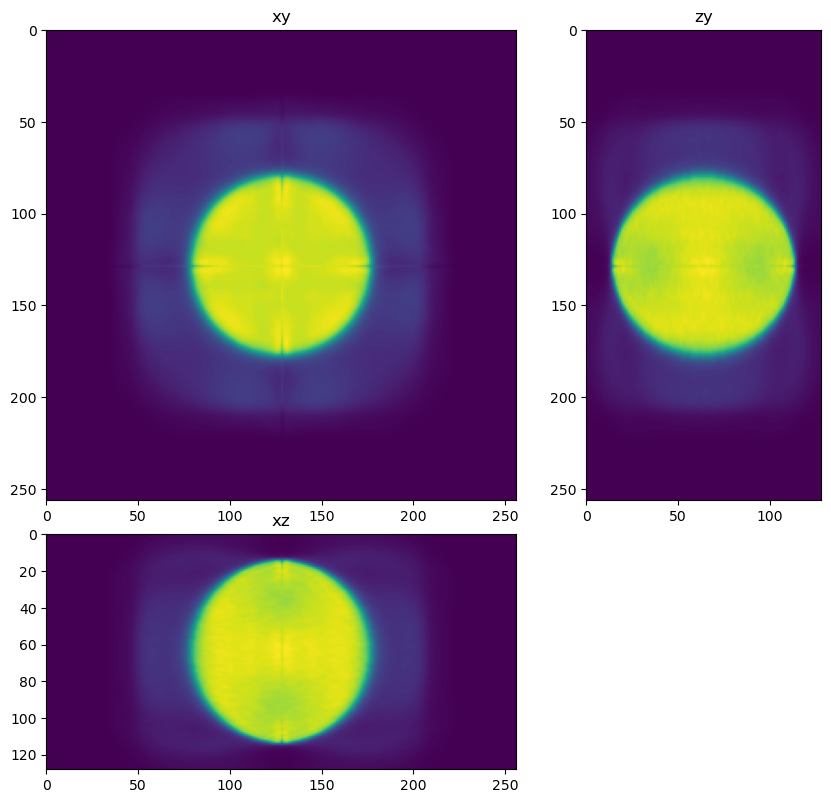

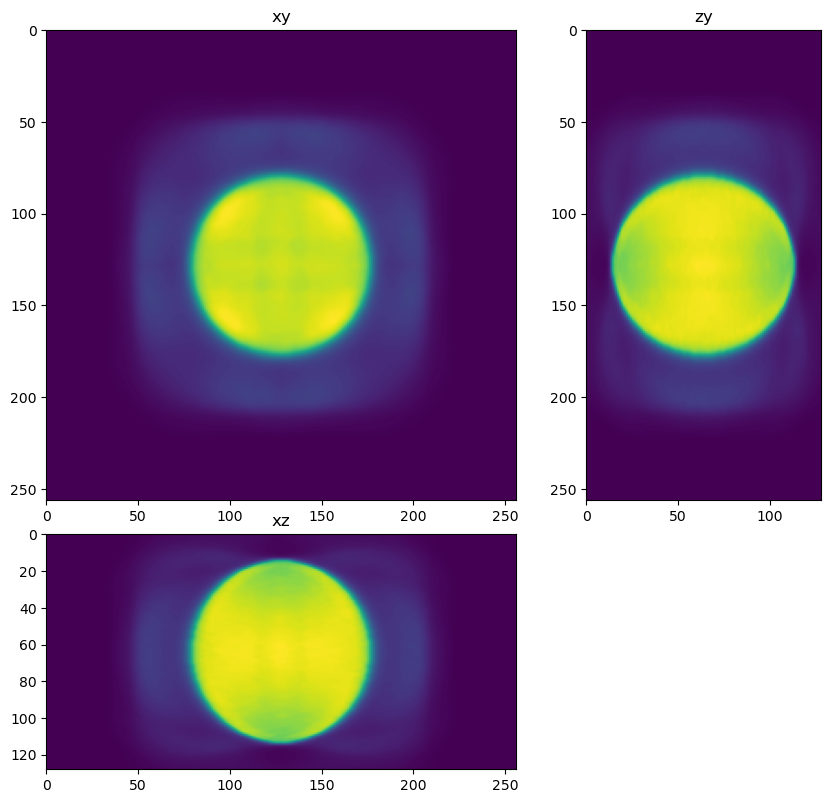

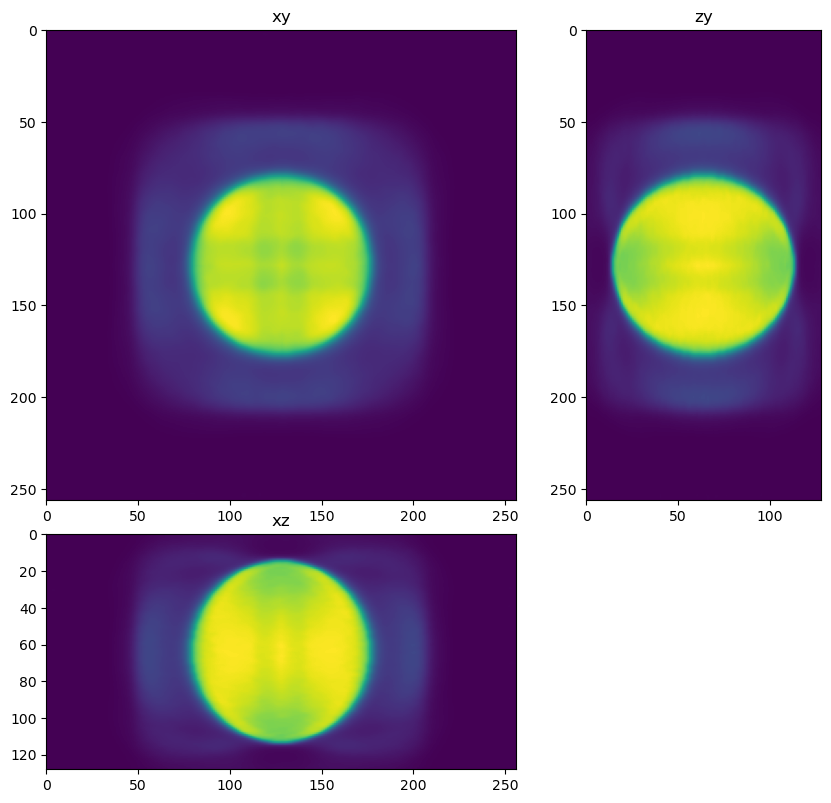

In [13]:
dimg = da.from_array(im,chunks=(z_chunk_size, y_chunk_size, x_chunk_size))

def decon_with_overlap(overlap):

    out = dimg.map_overlap(deconv_chunk, depth={0:0, 1:overlap, 2:overlap}, boundary='reflect', dtype=np.float32)
    decon_overlap_24 = out.compute(num_workers=1)
    dh.show_xyz_slice(decon_overlap_24,'tnia')

decon_with_overlap(0)
decon_with_overlap(12)
decon_with_overlap(32) 
  

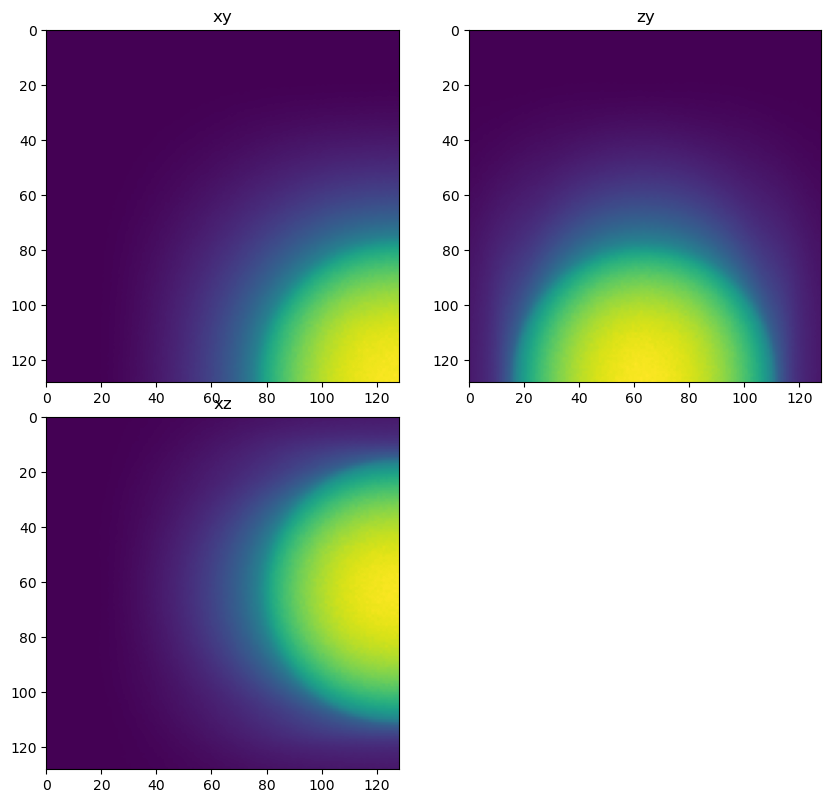

In [24]:
from tnia.plotting.projections import show_xyz_slice

im_cropped=im[:,0:im.shape[1]//2, 0:im.shape[2]//2]
im_cropped.shape
fig=show_xyz_slice(im_cropped, x_, y_, z_)

get lib

Richardson Lucy Started
0 10 20 30 40 50 60 70 80 90 
Richardson Lucy Finishedget lib

Richardson Lucy Started
0 10 20 30 40 50 60 70 80 90 
Richardson Lucy Finished

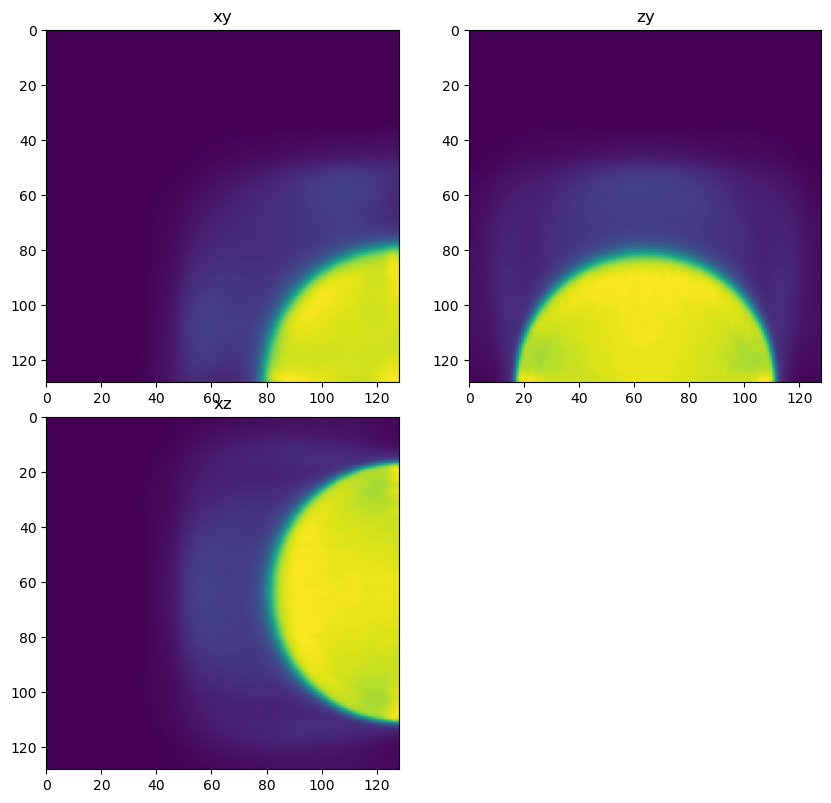

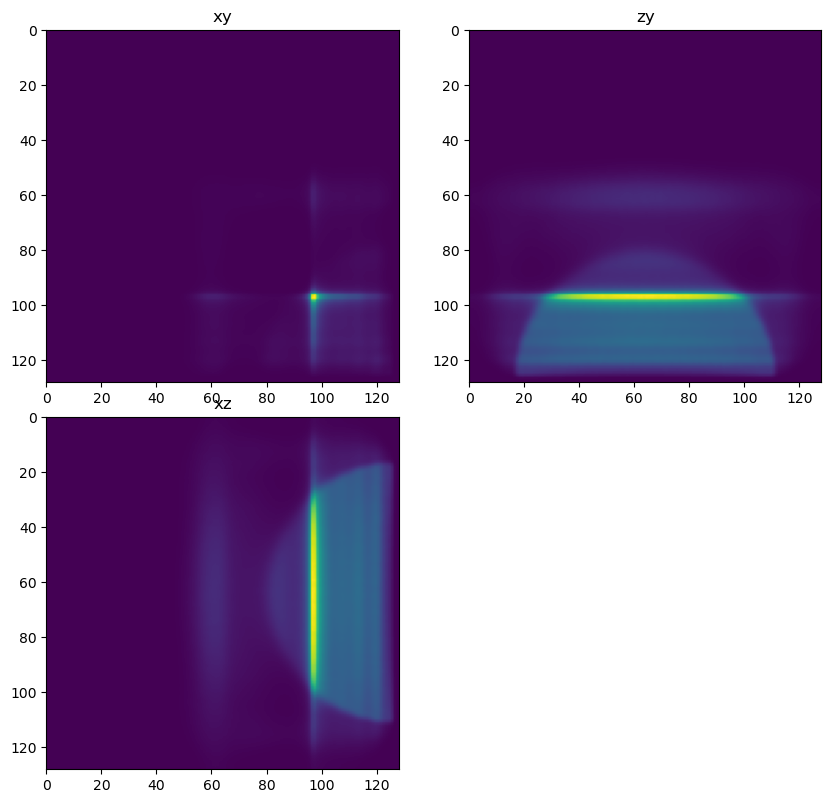

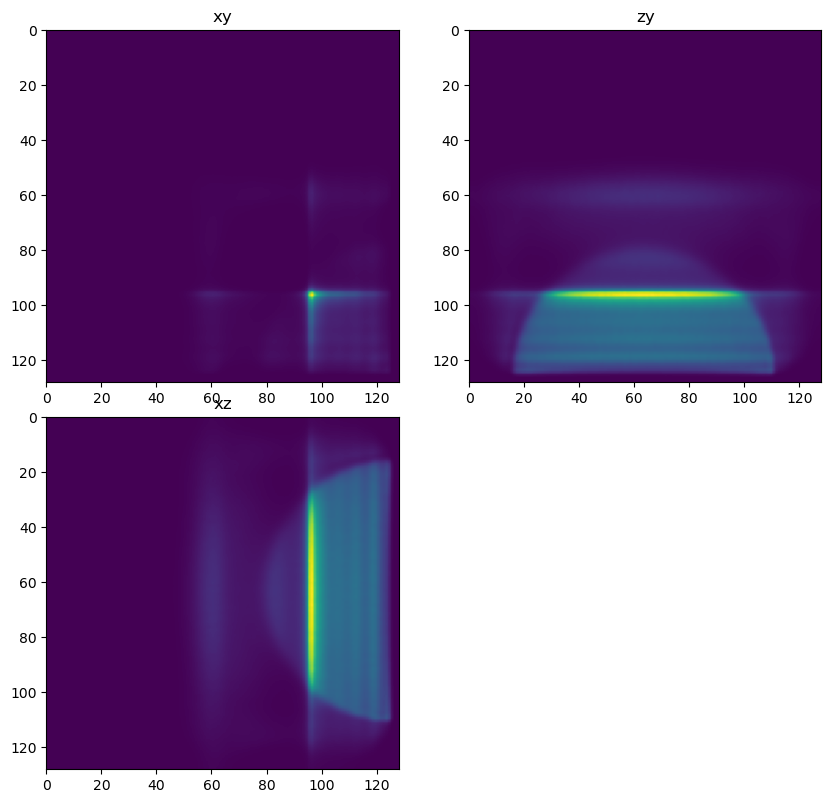

In [22]:

decon_nc = richardson_lucy_nc(im_cropped, psf_decon, iterations, reg)
decon_clij = richardson_lucy(im_cropped, psf_decon, iterations, reg)
decon_rlf = rl.doRLDeconvolutionFromNpArrays(im_cropped, psf_decon, niter=iterations, method='gpu', resAsUint8=False )

z_=im_cropped.shape[0]//2
y_=int(7*im_cropped.shape[1]//8)
x_=int(7*im_cropped.shape[2]//8)

fig=show_xyz_slice(decon_nc, x_, y_, z_)
fig=show_xyz_slice(decon_clij, x_, y_, z_)
fig=show_xyz_slice(decon_rlf, x_, y_, z_)

In [19]:
print(x_, y_, z_)

112 112 64
